## Setting up: 

In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import datetime
import pandas as pd
# importing the module
import json

%load_ext autoreload
%autoreload 2

#additional functions:
from add_functions.proj1_helpers import *
from add_functions.ml_methods_labs import *

### Load Data: 

- train.csv - Training set of 250000 events. The file starts with the ID column, then the label column (the y you have to predict), and finally 30 feature columns.
- test.csv - The test set of around 568238 events - Everything as above, except the label is missing.
- sample-submission.csv - a sample submission file in the correct format. The sample submission always predicts -1, that is ‘background’.

Note: 
- all variables are floating point, except PRI_jet_num which is integer
- variables prefixed with PRI (for PRImitives) are “raw” quantities about the bunch collision as measured by the detector.
- variables prefixed with DER (for DERived) are quantities computed from the primitive features, which were selected by the physicists of ATLAS.
- it can happen that for some entries some variables are meaningless or cannot be computed; in this case, their value is −999.0, which is outside the normal range of all variables.

In [2]:
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids = load_csv_data(DATA_TRAIN_PATH)

In [3]:
print(f'training data shape: y {y.shape}, X {tX.shape}')

training data shape: y (250000,), X (250000, 30)


In [4]:
### standardize data:
tX_std = standardize(tX)

#check if standardization method correct:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(tX)
#print(scaler.transform(tX))

StandardScaler()

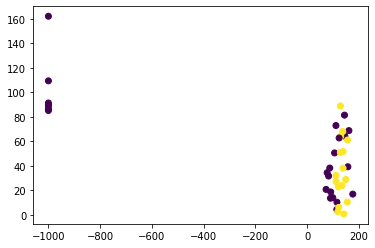

In [5]:
#Plot a few samples of first two coordinates:
NUM_POINTS = 40
plt.scatter(tX[:NUM_POINTS, 0], tX[:NUM_POINTS, 1], c=y[:NUM_POINTS])

## Implement ML methods:

You should take care of the following:
- Return type: Note that all functions should return: (w, loss), which is the last weight vector of the method, and the corresponding loss value (cost function). Note that while in previous labs you might have kept track of all encountered w for iterative methods, here we only want the last one.
- File names: Please provide all function implementations in a single python file, called implementations.py.
- All code should be easily readable and commented.
- Note that we might automatically call your provided methods and evaluate for correct implementation

### Cross validation:
Create cross validation method in order to evaluate the loss better. 

In [6]:
def cross_validation_sets(tX, y, percentage):
    """
    cross_validation_sets: separates tX and y randomly into training and validation sets. 
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - double percentage: percentage of training from original set (e.g. 0.8)
    @output: 
    - np.array(percentage*N,m) tX_train: training features
    - np.array(percentage*N,) y_train: training labels
    - np.array((1-percentage)*N,m) tX_val: validation features
    - np.array((1-percentage)**N,) y_val: validation labels
    """
    tX = pd.DataFrame(tX)
    y = pd.DataFrame(y)
    indices = tX.index.values

    #select a percentage of random rows random rows
    train_indices = np.random.choice(range(0, indices[-1]),
                                     size=int(indices[-1] * percentage),
                                     replace=False)
    #creates training and validation:
    tX_train = tX.iloc[train_indices].values
    tX_val = tX.drop(index=train_indices, axis=0).values
    y_train = y.iloc[train_indices].values[:, 0]
    y_val = y.drop(index=train_indices, axis=0).values[:, 0]

    assert (tX_train.shape[0] + tX_val.shape[0] == len(tX.index.values))
    assert (y_train.shape[0] + y_val.shape[0] == len(tX.index.values))

    return tX_train, y_train, tX_val, y_val

Different models that will be trainable:

In [7]:
models = {
    'LS_GD': 'Least squares with GD',
    'LS_SGD': 'Least squares with SGD',
    'LS_normal': 'Least squares with normal equations',
    'RR_normal': 'Ridge regression with normal equations',
    'LR': 'Logistic regression with GD'
}

Default json parameters for training, for special parameters take other file or create your own dictionary: 

In [8]:
with open('default_parameters.json') as json_file:
    default_parameters = json.load(json_file)

### Training: 
Global training function where each model can be called.

In [65]:
def train_model(tX,
                y,
                model='LS_GD',
                initial_w=np.zeros(tX.shape[1]),
                param=default_parameters):
    """
    train_model: trains a model according to their parameters in the dictionnary
    @input:
        - np.array(N,) y: labels
        - np.array(N,m) tX: features
        - string model: 'LS_GD', 'LS_SGD', 'LS_normal', 'RR_normal' or 'LR'
        - np.array(m,) initial_w: starting weights for GD and SGD
        - dictionary param: different parameters required for training (lr, lambda, etc)
    @output: 
        - np.array(m,) best_w: weights that got the smallest loss during cross-val
        - double avg_loss: average loss over validation sets during cross-val
    """
    # will keep last weights and last loss
    weights, loss = [], []
    parameters = param[model]
    # percentage of cross-validation sets
    PERCENTAGE = parameters['perc']
    # number of cross-validation
    K = parameters['K']
    # max iterations of GD
    MAX_ITERS = parameters['max_iters']
    # will keep all losses during training
    costs_ = np.zeros([K, MAX_ITERS])

    print(
        f'{models[model]} starting with: \nInitial_w: {initial_w},\nParameters:{parameters}'
    )
    print('------------------')
    print('START TRAINING:')

    for i in range(K):
        print(f'K = {i+1}')
        # create training and validation sets:
        tX_train, y_train, tX_val, y_val = cross_validation_sets(
            tX, y, PERCENTAGE)

        #start with initial_w:
        w = initial_w.copy()
        # keep tabs on losses during training
        cost_history = []

        # if RR_normal or LS_normal no GD:
        if model == 'RR_normal':
            w, cost_history = ridge_regression_update(tX_train, y_train,
                                                      tX_val, y_val,
                                                      parameters)
            cost = cost_history
            print(f'Final loss:{cost}')
        elif model == 'LS_normal':
            w, cost_history = least_squares_update(tX_train, y_train, tX_val,
                                                   y_val)
            cost = cost_history
            print(f'Final loss:{cost}')
        # else GD:
        else:
            for j in range(MAX_ITERS):
                if model == 'LR':
                    # calculate loss:
                    cost = cost_logistic(tX_val, y_val, w, parameters)
                    cost_history.append(cost)
                    # Update weights:
                    w = update_weights_logistic(tX_train, y_train, w,
                                                parameters)
                if model == 'LS_GD':
                    # calulate loss:
                    cost = MSE_loss(y_val, tX_val, w)
                    cost_history.append(cost)
                    # Update weights:
                    w = update_weights_LS_GD(tX_train, y_train, w, parameters)
                if model == 'LS_SGD':
                    # calulate loss:
                    cost = MSE_loss(y_val, tX_val, w)
                    cost_history.append(cost)
                    # update weights:
                    w = update_weights_LS_SGD(tX_train, y_train, w, parameters)

            print(f'Final loss:{cost}')
        # Add last weights and loss for auditing:
        weights.append(w)
        loss.append(cost)
        costs_[i] = cost_history
        print('------------------')
    print('Average loss: {avg_loss}'.format(avg_loss=np.mean(loss)))

    # best weights of min loss:
    best_w = weights[np.argmin(loss)]

    # Plot loss evolution for GD:
    if model != 'LS_normal' and model != 'RR_normal':
        print('------------------')
        print('Loss evolution:')
        plt.plot(costs_.T)
        plt.title(models[model])
        plt.legend(range(1, K + 1))

    return best_w, np.mean(loss)

### Least Squares GD: 
Linear regression using gradient descent. 

In [10]:
def gradient_MSE(y, tx, w):
    """
    gradient_MSE: calculates the gradient of the MSE function 
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) w: weights
    @output: np.array(m,) gradient of MSE
    """
    return (-1 / len(y)) * tx.T @ (y - tx @ w)

In [11]:
def MSE_loss(y, tx, w):
    """
    MSE_loss: calculates the MSE loss
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) w: weights
    @output: double, MSE loss
    """
    MSE = np.square(np.subtract(y,tx @ w)).mean()
    return MSE

# Test MSE loss function with random weight vector:
from sklearn.metrics import mean_squared_error
w = np.random.rand(tX_std.shape[1])
assert (mean_squared_error(y, tX_std @ w) == MSE_loss(y, tX_std, w))

In [12]:
def update_weights_LS_GD(tX, y, w, parameters):
    """
    update_weights_LS_GD: one step of GD with MSE
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) w: weights
    - dict parameters: dictionnary of required parameters
    @output: updated weights according to GD
    """    
    # get parameters:
    lr = parameters['lr']
    # calculate gradient:
    grad = gradient_MSE(y, tX, w)
    # update weights:
    w -= lr * grad
    return w

In [19]:
def least_squares_GD(tx, y, initial_w, parameters):
    """
    least_squares_GD: training with least squares GD
    @input:
    - np.array(N,m) tx: features
    - np.array(N,) y: labels
    - np.array(m,) initial_w: starting weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - double avg_loss: average loss over validation sets during cross-val
    """     
    model = 'LS_GD'
    best_w, avg_loss = train_model(tx, y, model, initial_w, parameters)
    return best_w, avg_loss

Least squares with GD starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.],
Parameters:{'lr': 0.01, 'max_iters': 100, 'perc': 0.8, 'K': 5}
------------------
START TRAINING:
K = 1
Final loss:0.834390825522732
------------------
K = 2
Final loss:0.8300372775094318
------------------
K = 3
Final loss:0.8388055792685432
------------------
K = 4
Final loss:0.838832352281616
------------------
K = 5
Final loss:0.8333517979343479
------------------
Average loss: 0.835083566503334
------------------
Loss evolution:


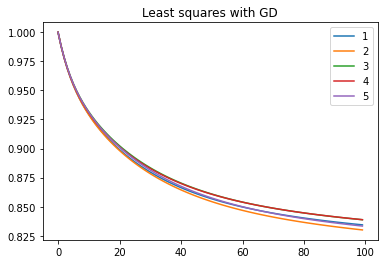

In [20]:
# Test of LS-GD:
initial_w = np.zeros(tX_std.shape[1])
best_w, avg_loss = least_squares_GD(tX_std, y, initial_w, default_parameters)

### Least Squares SGD:
Linear regression using stochastic gradient descent

In [24]:
def update_weights_LS_SGD(tX, y, w, parameters):
    """
    update_weights_LS_SGD: one step of SGD with MSE
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) w: weights
    - dict parameters: dictionnary of required parameters
    @output: updated weights according to SGD
    """   
    # get parameters:
    lr = parameters['lr']
    # batch_size to 1 for SGD, otherwise mini-batch:
    batch_size = parameters['batch_size']

    for minibatch_y, minibatch_tx in batch_iter(y, tX, batch_size):
        # calculate gradient on batch:
        grad = gradient_MSE(minibatch_y, minibatch_tx, w)
        # update weights:
        w -= lr * grad
    return w

In [25]:
def least_squares_SGD(tx, y,initial_w, parameters):
    """
    least_squares_SGD: training with least squares SGD
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) initial_w: starting weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - double avg_loss: average loss over validation sets during cross-val
    """     
    model = 'LS_SGD'
    best_w, avg_loss = train_model(tx, y, model, initial_w, parameters)
    return best_w, avg_loss

Least squares with SGD starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.],
Parameters:{'lr': 0.01, 'max_iters': 100, 'perc': 0.8, 'K': 5, 'batch_size': 1}
------------------
START TRAINING:
K = 1
Final loss:0.9516036691119437
------------------
K = 2
Final loss:0.9902031923109627
------------------
K = 3
Final loss:0.9375895068843042
------------------
K = 4
Final loss:0.8930632395244903
------------------
K = 5
Final loss:0.9036049221655201
------------------
Average loss: 0.9352129059994443
------------------
Loss evolution:


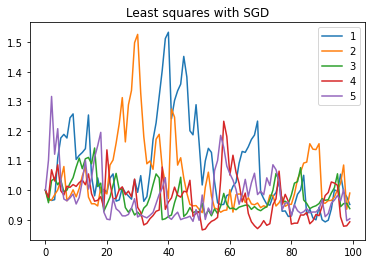

In [43]:
# Test of LS-SGD:
initial_w = np.zeros(tX_std.shape[1])
best_w, avg_loss = least_squares_SGD(tX_std, y, initial_w, default_parameters)

### Least Squares:
Least squares regression using normal equations. Solve $A^TAx = A^Ty$, Ax = b → x = np.linalg.solve(A, b)

In [28]:
def least_squares_update(tX_train, y_train, tX_val, y_val):
    """
    least_squares_update: weights with normal equations of least squares
    @input:
    - np.array(N,) y_train and y_val: training and validation labels
    - np.array(N,m) tX_train and tX_val: training and validation features
    @output: 
    - np.array(m,) w: weights 
    - double loss: MSE loss
    """        
    # "train": 
    w = np.linalg.solve(tX_train.T @ tX_train, tX_train.T @ y_train)
    # evaluate loss on validation set:
    loss = MSE_loss(y_val, tX_val, w)
    return w, loss

Pas nécessaire de garder cette fonction `least_squares` si c'est ok d'avoir juste une fx train, un peu inutile... 


In [32]:
def least_squares(y, tx, parameters):
    """
    least_squares: weights with normal equations of least squares
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    @output:
    - np.array(m,) best_w: weights with smallest loss during cross-val 
    - double avg_loss: average loss over validation sets during cross-val
    """     
    model = 'LS_normal'
    best_w, avg_loss = train_model(tx, y, model, initial_w, parameters)
    return best_w, avg_loss

In [44]:
# Test of LS_normal:
best_w, avg_loss = least_squares(y, tX_std, default_parameters)

Least squares with normal equations starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.],
Parameters:{'max_iters': 1, 'perc': 0.8, 'K': 5}
------------------
START TRAINING:
K = 1
Final loss:0.7741741752136655
------------------
K = 2
Final loss:0.7776457355609057
------------------
K = 3
Final loss:0.7809925147302643
------------------
K = 4
Final loss:0.7774687298974077
------------------
K = 5
Final loss:0.7765126545366163
------------------
Average loss: 0.7773587619877719


### Ridge Regression: 
Ridge regression using normal equations. $w^* = (X^T X+\lambda I)^{-1}X^Ty$

In [39]:
def ridge_regression_update(tX_train, y_train, tX_val, y_val, parameters):
    """
    least_squares_update: weights with normal equations of least squares
    @input:
    - np.array(N,) y_train and y_val: training and validation labels
    - np.array(N,m) tX_train and tX_val: training and validation features
    - dict parameters: dictionnary of required parameters
    @output:
    - np.array(m,) w: weights 
    - double loss: MSE loss
    """
    # get parameters:
    lambda_ = parameters['lambda_']

    # "train":
    w = np.linalg.solve(
        tX_train.T @ tX_train + lambda_ * np.eye(tX_train.shape[1]),
        tX_train.T @ y_train)

    # evaluate loss on validation set:
    loss = MSE_loss(y_val, tX_val, w)
    return w, loss

A nouveau, pas nécessaire de garder cette fonction `ridge_regression` si c'est ok d'avoir juste une fx train, un peu inutile...

In [40]:
def ridge_regression(y, tx, parameters):
    """
    ridge_regression: weights with normal equations of ridge regression
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    @output:
    - np.array(m,) best_w: weights with smallest loss during cross-val 
    - double avg_loss: average loss over validation sets during cross-val
    """     
    model = 'RR_normal'
    best_w, avg_loss = train_model(tx, y, model, initial_w, parameters)
    return best_w, avg_loss

In [46]:
# Test of RR_normal:
best_w, avg_loss = ridge_regression(y, tX_std,default_parameters)

Ridge regression with normal equations starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.],
Parameters:{'max_iters': 1, 'perc': 0.8, 'K': 5, 'lambda_': 0.02}
------------------
START TRAINING:
K = 1
Final loss:0.7794303165920804
------------------
K = 2
Final loss:0.7817468891206232
------------------
K = 3
Final loss:0.7760367481968747
------------------
K = 4
Final loss:0.7748061354599156
------------------
K = 5
Final loss:0.7790588176156775
------------------
Average loss: 0.7782157813970343


### Logistic (regularized) regression: 
Logistic regression using gradient descent or SGD. 
https://github.com/SSaishruthi/LogisticRegression_Vectorized_Implementation/blob/master/Logistic_Regression.ipynb

https://machinelearningmedium.com/2017/09/15/regularized-logistic-regression/

- cost : $J(w) = -1/m (-y^T log (h)-(1-y)^T log (1-h)) + \lambda/(2m)||w||^2 ; h = sigmoid(Xw)$

Regularized logistic regression using gradient descent or SGD. $ w^* = min_w \sum_{i=1}^n log(1+exp(-y_i w^T x_i)) +\lambda ‖w‖^2$

In [47]:
def sigmoid_activation(z):
    """
    sigmoid_activation: calculates the sigmoid activation of a vector z
    @output: np.array(m,) 
    """
    return 1.0 / (1.0 + np.exp(-z))

In [48]:
def cost_logistic(tX, y, w, parameters):
    """
    cost_logistic: calculates the logistic (regularized) loss
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) w: weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - double cost: logistic loss
    """     
    # get parameters:
    lambda_ = parameters['lambda_']
    
    predictions = sigmoid_activation(tX @ w)
    m = y.shape[0]
    
    #Take the sum of both costs: error when label=1 + error when label=0
    cost = -y * np.log(predictions) - (1 - y) * np.log(1 - predictions)
    
    #Take the average cost:
    cost = cost.sum() / m

    # regularizer:
    if lambda_:
        cost += (lambda_ / (2 * m)) * w.T @ w
    return cost

In [49]:
def update_weights_logistic(tX, y, w, parameters):
    """
    update_weights_logistic: one iteration with GD on logistic (regularized) loss
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tX: features
    - np.array(m,) w: weights to be updated
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) w: new weights
    """     
    
    # get parameters:
    lr = parameters['lr']
    lambda_ = parameters['lambda_']
    m = len(tX)
    
    #Get Predictions:
    predictions = sigmoid_activation(np.dot(tX, w))
    
    # slope of the cost function across all observations
    gradient = (tX.T @ (predictions - y))

    # if regularization
    if lambda_:
        gradient += lambda_ * w
    
    gradient /= m
    
    # Subtract from our weights to minimize cost
    w -= lr * gradient
    return w

In [50]:
def logistic_regression(y, tx, initial_w, parameters):
    """
    logistic_regression: logistic (regularized) regression with GD
    @input:
    - np.array(N,) y: labels
    - np.array(N,m) tx: features
    - np.array(m,) initial_w: starting weights
    - dict parameters: dictionnary of required parameters
    @output: 
    - np.array(m,) best_w: weights that got the smallest loss during cross-val
    - double avg_loss: average loss over validation sets during cross-val
    """     
    model = 'LR'
    best_w, avg_loss = train_model(tx, y, model, initial_w, parameters)
    return best_w, avg_loss

Logistic regression with GD starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.],
Parameters:{'lambda_': 0.02, 'lr': 0.01, 'max_iters': 200, 'perc': 0.8, 'K': 5}
------------------
START TRAINING:
K = 1
Final loss:0.3745166337711164
------------------
K = 2
Final loss:0.3670861644568867
------------------
K = 3
Final loss:0.38193950696438267
------------------
K = 4
Final loss:0.37041611232441396
------------------
K = 5
Final loss:0.3700461266412937
------------------
Average loss: 0.37280090883161876
------------------
Loss evolution:


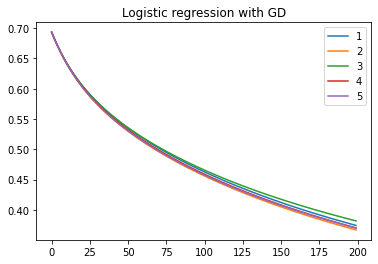

In [52]:
# Test of logistic regression:
# set lambda to None if no regularization:
parameters['lambda_'] = None
initial_w = np.zeros(tX_std.shape[1])
best_w, avg_loss = logistic_regression(y, tX_std,initial_w, default_parameters)

Logistic regression with GD starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.],
Parameters:{'lambda_': 0.02, 'lr': 0.01, 'max_iters': 200, 'perc': 0.8, 'K': 5}
------------------
START TRAINING:
K = 1
Final loss:0.3808694647992298
------------------
K = 2
Final loss:0.38269858710783516
------------------
K = 3
Final loss:0.3732730254835719
------------------
K = 4
Final loss:0.3761144518720039
------------------
K = 5
Final loss:0.3776986878195586
------------------
Average loss: 0.3781308434164399
------------------
Loss evolution:


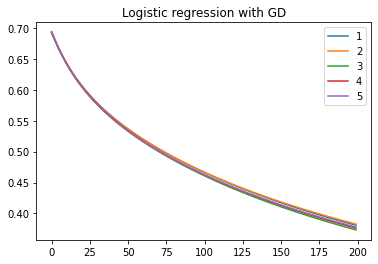

In [53]:
# Test of logistic regularized regression:
initial_w = np.zeros(tX_std.shape[1])
best_w, avg_loss = logistic_regression(y, tX_std,initial_w, default_parameters)

## Training with special parameters: 

For other parameters than in the default, change json or create a new dict.

Logistic regression with GD starting with: 
Initial_w: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.],
Parameters:{'lambda_': 0.02, 'lr': 0.01, 'max_iters': 200, 'perc': 0.8, 'K': 5}
------------------
START TRAINING:
K = 1
Final loss:0.38082367095793107
------------------
K = 2
Final loss:0.37823572787526116
------------------
K = 3
Final loss:0.3806015352789875
------------------
K = 4
Final loss:0.3753177466601393
------------------
K = 5
Final loss:0.3803616662515766
------------------
Average loss: 0.3790680694047791
------------------
Loss evolution:


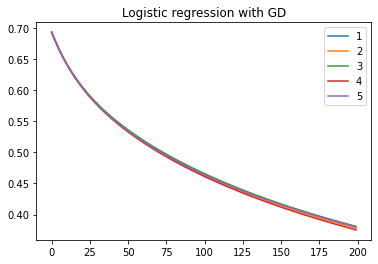

In [72]:
## Training with k-fold:
model = 'LR'
initial_w = np.zeros(tX_std.shape[1])

with open('parameters.json') as json_file:
    parameters = json.load(json_file)

best_w, avg_loss = train_model(tX_std, y, model, initial_w, parameters)

## Generate predictions and save ouput in csv format for submission:

In [83]:
DATA_TEST_PATH = '../data/test.csv' # TODO: download test data and supply path here 
_, tX_test, ids_test = load_csv_data(DATA_TEST_PATH)
print(f'test data shape: X {tX_test.shape}')

test data shape: X (568238, 30)


In [84]:
# standard par rapport à moyenne et std de train:
mean_train = np.mean(tX, axis=0)
std_train = np.std(tX - mean_train, axis=0)
test_data = standardize_with_meanstd(tX_test, mean_train, std_train)

In [85]:
# Choose method: 
from datetime import date
today = date.today()

# parameters:
params = ''
for param in parameters[model]:
    params+= param+'='+str(parameters[model][param])+','

test_prediction = predict_labels(best_w, test_data)
OUTPUT_PATH = '../data/results/y_pred_' + model + '_'+str(today)+'_'+params+'.csv'
ids_test = pd.read_csv('../data/sample-submission.csv')['Id']
create_csv_submission(ids_test, test_prediction, OUTPUT_PATH)